# Small data and deep learning
This mini-project proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should not exceed 2MB. Please name your notebook (LASTNAME)\_(FIRSTNAME).ipynb, zip/tar it with any necessary files required to run your notebook, in a compressed file named (LASTNAME)\_(FIRSTNAME).X where X is the corresponding extension. Zip/tar files exceeding 2MB will not be considered for grading. Submit the compressed file via the submission link provided on the website of the class.__

You can use https://colab.research.google.com/ to run your experiments.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets.utils import download_url, check_integrity

from PIL import Image
import math
import os
import os.path
import numpy as np
import sys
import pickle

import torch.utils.data as data

## Training set creation
__Question 1:__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

#### Restricted training dataset class

In [133]:
from torchvision.datasets.cifar import CIFAR10

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

class myCIFAR10_100samples(CIFAR10):
    
    def __init__(self, root, train=True,transform=None, target_transform=None, download=False):
        super().__init__(root,transform = transform)

    def restrict_train_data(self, nb_of_samples_1, nb_of_samples_2):
        self.data= self.data[nb_of_samples_1:nb_of_samples_2]
        self.targets = self.targets[nb_of_samples_1:nb_of_samples_2] 
        

#### Loading and inspecting training dataset

CIFAR_original


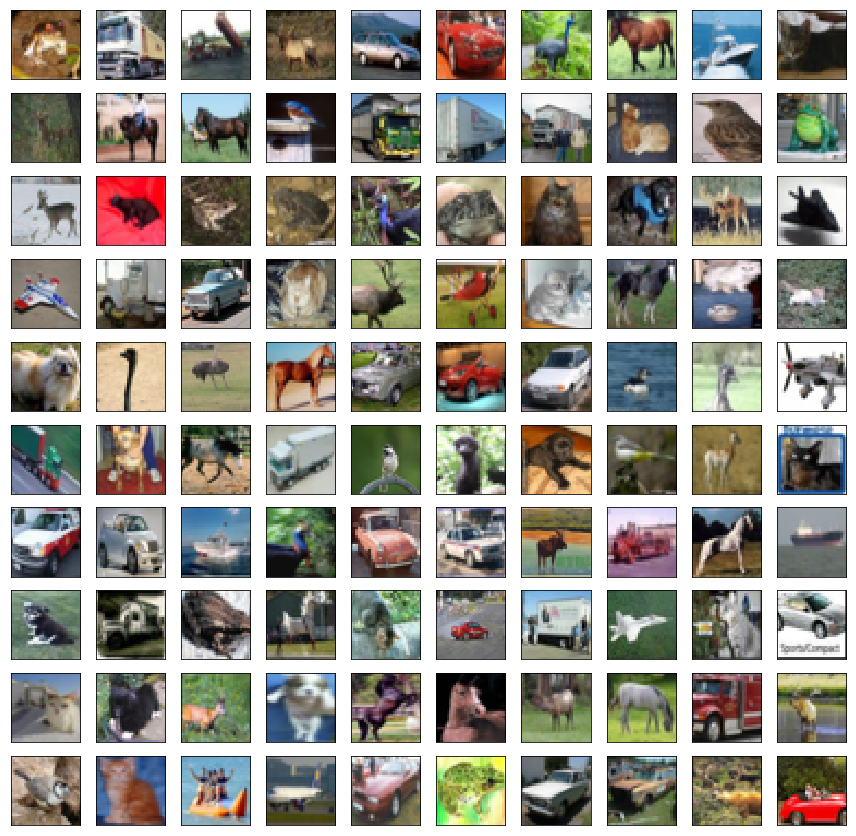

Dataset myCIFAR10_100samples
    Number of datapoints: 100
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
                         )
    Target Transforms (if any): None
(100, 32, 32, 3) 



In [134]:
CIFAR_train = myCIFAR10_100samples(root='./data', transform = transform)
CIFAR_train.restrict_train_data(0,100)

trainloader = torch.utils.data.DataLoader(CIFAR_train, batch_size=10,shuffle=True )

print('CIFAR_original')
fig,a = plt.subplots(10,10, figsize=(15,15))
for i in range(100):
    a[i//10,i%10].imshow(CIFAR_train.data[i])
    a[i//10,i%10].set_xticks([])
    a[i//10,i%10].set_yticks([])
plt.show()

print(CIFAR_train)
print(CIFAR_train.data.shape,'\n')

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

#### Test dataset and loader

In [135]:
CIFAR_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(CIFAR_test, batch_size=1, shuffle=True )

Files already downloaded and verified


***NB***: Additionnaly, a validation set composed of the net 100 images of the dataset is used in order to fine-tune the models and find best learning parameters.

#### Validation dataset and loader

In [136]:
CIFAR_val = myCIFAR10_100samples(root='./data', transform = transform)
CIFAR_val.restrict_train_data(100,200)

print(CIFAR_val.data.shape)
valloader = torch.utils.data.DataLoader(CIFAR_val, shuffle=True,  batch_size=10)

(100, 32, 32, 3)


## Testing procedure
__Question 2:__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

Text(0.5, 1.0, 'Testing set')

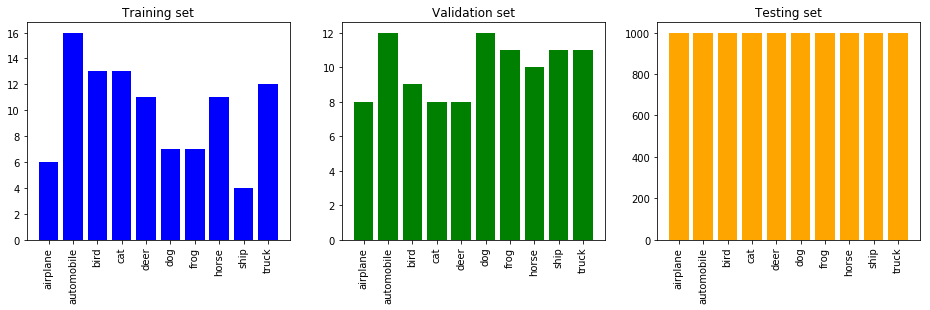

In [137]:
fig, a = plt.subplots(1,3, figsize=(16,4))
keys, counts = np.unique(CIFAR_train.targets, return_counts=True)
a[0].bar(CIFAR_train.classes, counts, color='blue')
a[0].set_xticklabels(CIFAR_train.classes,rotation=90)
a[0].set_title('Training set')

keys, counts = np.unique(CIFAR_val.targets, return_counts=True)
a[1].bar(CIFAR_val.classes, counts,color='green')
a[1].set_xticklabels(CIFAR_val.classes,rotation=90)
a[1].set_title('Validation set')

keys, counts = np.unique(CIFAR_test.targets, return_counts=True)
a[2].bar(CIFAR_test.classes, counts,color='orange')
a[2].set_xticklabels(CIFAR_test.classes,rotation=90)
a[2].set_title('Testing set')


<font color='blue'>
    
The evaluation of the training procedure might be hard to assess as the training data is a very small and unbalanced set of images. Hence there might be ***unseen instance types in classes*** in the testing set not seen at train time. An other problem corresponds to **overfitting** of the image when dealing with such small dataset. The training process will quickly lead the network to learn features that corresponds only on thoses images and will have struggle to generalize well.

In this context, a solution would be to **level the number of instances** of each classes in the dataset, hence promoting a fairer training for each classe. Another solution during the training consist in **early stopping** as validation and training loss will diverge as some point. Hence we will use a validation set of 100 data points to detect this overfitting phenomenon. Additionally, **dataset augmentation techniques** such as adding special transformation that conserves classe-specific information might help the model generalize. Finally, incorporating a priori in the model, such as distribution on statistics of points for each class (as in the further discussed **weak supervised framework**) might help. 

The metric taken to assess the model is also very important since metrics might have some bias when dealing with **unbalanced datasets**. For exemple, accuracy might be biased by good results on overpopulated classes such as automobile. This might hide poor results on other classes. To tackle this problem, it might be interesting to crossvalidate results w.r.t to other metrics such as **precision, recall and f1 score**.

</font>

# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performances with reported number from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context those researchers had access to GPUs.

## ResNet architectures

__Question 3:__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1409.1556 ). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (~5 minutes).

#### Pytorch functional imports and training and testing pipelines

In [138]:
import torchvision.models as models
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

def train_and_val(net,trainloader,valloader,epoch=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    loss_train=[]
    loss_val = []

    for epoch in range(epoch):  # loop over the dataset multiple times

        for g in optimizer.param_groups: # decreasing learning rate by 10% every epoch
            g['lr'] = 0.90*g['lr']

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every mini-batches
                print('Epoch:{}, batch_number:{}, loss:{}'.format(epoch+1,i+1, running_loss/10))
                running_loss = 0.0
                with torch.no_grad():
                    for j, data in enumerate(valloader, 0):
                        inputs, labels = data
                        outputs = net(inputs)
                        lossv = criterion(outputs, labels)
                        loss_val.append(lossv.item())
                    
    return loss_train,loss_val

def testing(testloader, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i,data in enumerate(testloader):
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if i % 100 == 99:    # print every 2000 mini-batches
                print(i, 'ème tested image')
    print('Accuracy of the network: %d %%' % (
        100 * correct / total))

#### Resnet-18 

In [139]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

def test():
    net = ResNet18()
    y = net(torch.randn(1,3,32,32))
    print(y.size())
    
test()

torch.Size([1, 10])


In [140]:
resnet18 = ResNet18()
loss_train_resnet, loss_val_resnet = train_and_val(resnet18,trainloader, valloader, epoch=10)

Epoch:1, batch_number:10, loss:2.361436295509338
Epoch:2, batch_number:10, loss:2.158283460140228
Epoch:3, batch_number:10, loss:1.9574421167373657
Epoch:4, batch_number:10, loss:1.564739501476288
Epoch:5, batch_number:10, loss:1.2283700585365296
Epoch:6, batch_number:10, loss:0.8135454773902893
Epoch:7, batch_number:10, loss:0.5975885301828384
Epoch:8, batch_number:10, loss:0.3551038756966591
Epoch:9, batch_number:10, loss:0.2552380755543709
Epoch:10, batch_number:10, loss:0.15359007492661475


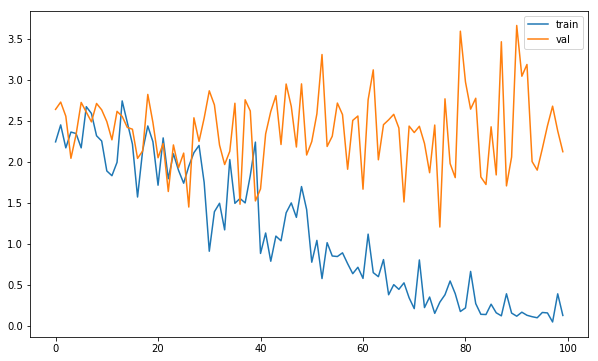

In [141]:
plt.figure(figsize=(10,6))
plt.plot(loss_train_resnet, label='train')
plt.plot(loss_val_resnet, label='val')
plt.legend()

In [142]:
testing(trainloader, resnet18)

Accuracy of the network: 98 %


In [143]:
testing(valloader, resnet18)

Accuracy of the network: 23 %


In [34]:
testing(testloader, resnet18)

99 ème tested image
199 ème tested image
299 ème tested image
399 ème tested image
499 ème tested image
599 ème tested image
699 ème tested image
799 ème tested image
899 ème tested image
999 ème tested image
1099 ème tested image
1199 ème tested image
1299 ème tested image
1399 ème tested image
1499 ème tested image
1599 ème tested image
1699 ème tested image
1799 ème tested image
1899 ème tested image
1999 ème tested image
2099 ème tested image
2199 ème tested image
2299 ème tested image
2399 ème tested image
2499 ème tested image
2599 ème tested image
2699 ème tested image
2799 ème tested image
2899 ème tested image
2999 ème tested image
3099 ème tested image
3199 ème tested image
3299 ème tested image
3399 ème tested image
3499 ème tested image
3599 ème tested image
3699 ème tested image
3799 ème tested image
3899 ème tested image
3999 ème tested image
4099 ème tested image
4199 ème tested image
4299 ème tested image
4399 ème tested image
4499 ème tested image
4599 ème tested image

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|Resnet18| ***10*** | ***100%*** | ***20%*** |

## VGG-like architectures

__Question 4:__ Same question as before, but with a *VGG*. Which model do you recommend?

In [38]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

class VGG(nn.Module):
    def __init__(self, vgg_config, num_classes=10, cfg=cfg):
        super(VGG, self).__init__()
        self.cfg = cfg
        self.features = self._make_layers(vgg_config,batch_norm=True)
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def _make_layers(self, vgg_config, batch_norm=False):
        layers = []
        in_channels = 3
        for v in self.cfg[vgg_config]:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = v
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

def test():
    net = VGG('VGG11')
    x = torch.randn(2,3,32,32)
    y = net(x)
    print(y.size())
    
test()

torch.Size([2, 10])


In [42]:
vgg11 = VGG('VGG11')
loss_train_vgg, loss_val_vgg = train_and_val(vgg11,trainloader,valloader,epoch=10)

Epoch:1, batch_number:10, loss:2.410981607437134
Epoch:2, batch_number:10, loss:2.4183099269866943
Epoch:3, batch_number:10, loss:2.6739373207092285
Epoch:4, batch_number:10, loss:1.942766535282135
Epoch:5, batch_number:10, loss:1.606972050666809
Epoch:6, batch_number:10, loss:1.281217098236084
Epoch:7, batch_number:10, loss:1.0705510079860687
Epoch:8, batch_number:10, loss:0.6098103404045105
Epoch:9, batch_number:10, loss:0.31605664640665054
Epoch:10, batch_number:10, loss:0.25775191485881804


In [47]:
vgg13 = VGG('VGG13')
loss_train_vgg_13, loss_val_vgg_13 = train_and_val(vgg13,trainloader,valloader,epoch=20)

Epoch:1, batch_number:10, loss:2.5767828226089478
Epoch:2, batch_number:10, loss:2.4708808422088624
Epoch:3, batch_number:10, loss:2.213457131385803
Epoch:4, batch_number:10, loss:2.1220678329467773
Epoch:5, batch_number:10, loss:2.143971931934357
Epoch:6, batch_number:10, loss:1.6635093092918396
Epoch:7, batch_number:10, loss:1.5123396873474122
Epoch:8, batch_number:10, loss:1.4632400095462799
Epoch:9, batch_number:10, loss:1.245401644706726
Epoch:10, batch_number:10, loss:0.9287539184093475
Epoch:11, batch_number:10, loss:0.8140263557434082
Epoch:12, batch_number:10, loss:0.7328107833862305
Epoch:13, batch_number:10, loss:0.40225363671779635
Epoch:14, batch_number:10, loss:0.28871468603610995
Epoch:15, batch_number:10, loss:0.27597631961107255
Epoch:16, batch_number:10, loss:0.2984129719436169
Epoch:17, batch_number:10, loss:0.1622421510517597
Epoch:18, batch_number:10, loss:0.07772675100713969
Epoch:19, batch_number:10, loss:0.05864490419626236
Epoch:20, batch_number:10, loss:0.0872

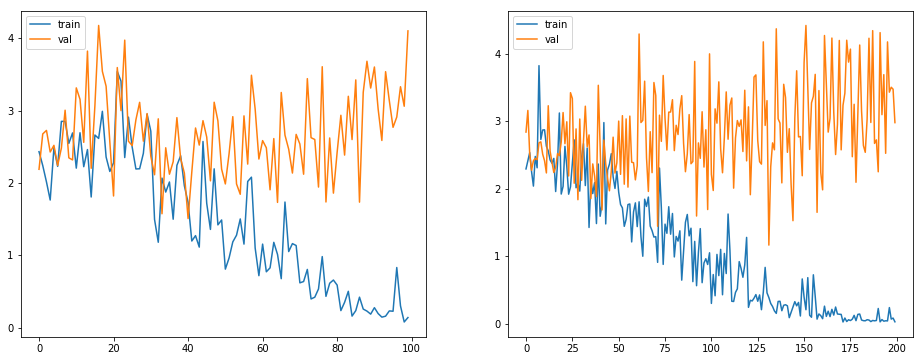

In [57]:
fig, a = plt.subplots(1,2,figsize=(16,6))
a[0].plot(loss_train_vgg,label='train')
a[0].plot(loss_val_vgg,label='val')
a[0].legend()

a[1].plot(loss_train_vgg_13,label=('train'))
a[1].plot(loss_val_vgg_13,label='val')
a[1].legend()

In [45]:
testing(trainloader, vgg11)

Accuracy of the network: 98 %


In [46]:
testing(valloader, vgg11)

Accuracy of the network: 24 %


In [58]:
testing(trainloader, vgg13)

Accuracy of the network: 99 %


In [59]:
testing(valloader, vgg13)

Accuracy of the network: 30 %


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   VGG-11  | ***10*** | ***98%*** | ***24%*** |
|   VGG-13  | ***20*** | ***99%*** | ***30%*** |

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 5:__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [60]:
vgg16_pretrained = models.vgg16(pretrained=True)

In [61]:
[child for child in vgg16_pretrained.named_children()]

[('features', Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256,

In [63]:
for param in vgg16_pretrained.parameters():
    param.requires_grad = False
    
vgg16_pretrained.classifier = nn.Sequential(nn.Linear(25088, 4096), 
                                               nn.ReLU(), 
                                               nn.Dropout(0.4),
                                               nn.Linear(4096, 1024), 
                                               nn.ReLU(), 
                                               nn.Dropout(0.4),
                                               nn.Linear(1024, 10),
                                               nn.Softmax(dim=1))

loss_train_vgg_pretrained, loss_val_vgg_pretrained = train_and_val(vgg16_pretrained,trainloader,valloader,epoch=20)

Epoch:1, batch_number:10, loss:2.296255326271057
Epoch:2, batch_number:10, loss:2.1753909587860107
Epoch:3, batch_number:10, loss:1.991888129711151
Epoch:4, batch_number:10, loss:1.8244871139526366
Epoch:5, batch_number:10, loss:1.7130159735679626
Epoch:6, batch_number:10, loss:1.6347355961799621
Epoch:7, batch_number:10, loss:1.6111129641532898
Epoch:8, batch_number:10, loss:1.555889642238617
Epoch:9, batch_number:10, loss:1.5400220036506653
Epoch:10, batch_number:10, loss:1.5172523736953736
Epoch:11, batch_number:10, loss:1.508672571182251
Epoch:12, batch_number:10, loss:1.4894325971603393
Epoch:13, batch_number:10, loss:1.4784928679466247
Epoch:14, batch_number:10, loss:1.4796890139579773
Epoch:15, batch_number:10, loss:1.47710942029953
Epoch:16, batch_number:10, loss:1.4772368669509888
Epoch:17, batch_number:10, loss:1.4766469478607178
Epoch:18, batch_number:10, loss:1.4823245048522948
Epoch:19, batch_number:10, loss:1.474459969997406
Epoch:20, batch_number:10, loss:1.4761449337005

In [64]:
testing(trainloader, vgg16_pretrained)

Accuracy of the network: 99 %


In [65]:
testing(valloader, vgg16_pretrained)

Accuracy of the network: 40 %


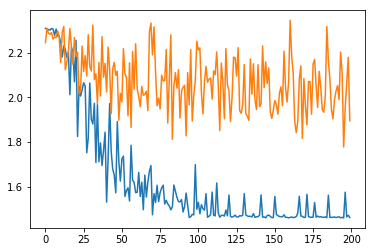

In [66]:
plt.plot(loss_train_vgg_pretrained)
plt.plot(loss_val_vgg_pretrained)

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   VGG_(ImageNet pretraining)  | 20 | 100% | 48% |

#### (An other implementation for retraining last onvolutional layer)

## DCGan features

GANs correspond to an unsupervised technique for generating images. In https://arxiv.org/pdf/1511.06434.pdf, Sec. 5.1 shows that the representation obtained from the Discriminator has some nice generalization properties on CIFAR10.

__Question 6:__  Using for instance a pretrained model from https://github.com/soumith/dcgan.torch combined with https://github.com/pytorch/examples/tree/master/dcgan, propose a model to train on $\mathcal{X}_{\text{train}}$. Train it and report its accuracy.

*Hint:* You can use the library: https://github.com/bshillingford/python-torchfile to load the weights of a model from torch(Lua) to pytorch(python).

In [67]:
class Discriminator(nn.Module):
    def __init__(self, nc=3, ndf=64):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 2, 2, 0, bias=False),
            nn.Sigmoid()
        )
        self.load_state_dict(torch.load('./netD_epoch_199.pth',map_location='cpu'))
        
        layers = list([child for child in self.children()][0][0:11])
        layers+= [nn.AvgPool2d(kernel_size=1, stride=1)]
        self.main= nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.Linear(2048, 10),
                   nn.Softmax(dim=1))

    def forward(self, x):
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
D=Discriminator()
D

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): AvgPool2d(kernel_size=1, stride=1, padding=0)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=10, bias=True

In [69]:
loss_train_DCGAN, loss_val_DCGAN = train_and_val(D,trainloader,valloader,epoch=30)

Epoch:1, batch_number:10, loss:2.2877625703811644
Epoch:2, batch_number:10, loss:2.216111421585083
Epoch:3, batch_number:10, loss:2.1088099360466
Epoch:4, batch_number:10, loss:1.9945311546325684
Epoch:5, batch_number:10, loss:1.9251996278762817
Epoch:6, batch_number:10, loss:1.8698894262313843
Epoch:7, batch_number:10, loss:1.8198498725891112
Epoch:8, batch_number:10, loss:1.7725014090538025
Epoch:9, batch_number:10, loss:1.7423267364501953
Epoch:10, batch_number:10, loss:1.720981276035309
Epoch:11, batch_number:10, loss:1.6918918371200562
Epoch:12, batch_number:10, loss:1.6702049255371094
Epoch:13, batch_number:10, loss:1.6466776371002196
Epoch:14, batch_number:10, loss:1.636977779865265
Epoch:15, batch_number:10, loss:1.6183989286422729
Epoch:16, batch_number:10, loss:1.6198902368545531
Epoch:17, batch_number:10, loss:1.6108896017074585
Epoch:18, batch_number:10, loss:1.6014538168907166
Epoch:19, batch_number:10, loss:1.5992298603057862
Epoch:20, batch_number:10, loss:1.601523756980

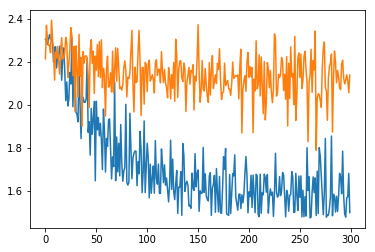

In [70]:
plt.plot(loss_train_DCGAN)
plt.plot(loss_val_DCGAN)

In [71]:
testing(trainloader, D)

Accuracy of the network: 89 %


In [72]:
testing(valloader, D)

Accuracy of the network: 40 %


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   DCGAN Discriminator  | ***30*** | 83% | 36% |

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 7:__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

The problem of using geometric transformations on inputs of such small dimensions is that they might yeald uninformative exemples for the training. Indeed, a scaling factor of 2 will yeald output of only 16-pixels width which hardly represents complex and discriminative patterns to grasp for the network. Same exemples can be shown for other transformation. Hence we should carefuly use the transformations of our data. 

> **Translations** will be restricted to one-half of the image dimension (16x16) and a zero-padding  will be added to the blnk part of the translated image.

> **Rotation angles** will be stochastically taken into $[0,2\pi[$

> **Scaling factor** will be taken into $\alpha = [1/2,2]$

> **color changes** 

## Data augmentations

__Question 8:__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ and __Question 4__ with them and report the accuracies.

In [131]:
Data_augmentation = {'train': transforms.Compose([transforms.RandomApply([transforms.RandomAffine(45, translate=(1/4,1/4), scale=(1/1.5,1.5), shear=None, resample=False, fillcolor=0)], p=0.5),
                                transforms.RandomApply([transforms.ColorJitter(brightness=(0.9,1.1))], p=0.5),
                                transforms.RandomApply([transforms.ColorJitter(contrast=(0.9,1.1))], p=0.5),
                                transforms.RandomApply([transforms.ColorJitter(saturation=(0.9,1.1))], p=0.5),                  
                                #transforms.RandomVerticalFlip(p=0.5),
                                transforms.RandomCrop(32, 4),
                                transforms.RandomHorizontalFlip(p=0.5),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]),
                     'val': transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])}

CIFAR_aug_train = myCIFAR10_100samples(root='./data', transform = Data_augmentation['train'])
CIFAR_aug_train.restrict_train_data(0,100)
trainloader_aug = torch.utils.data.DataLoader(CIFAR_aug_train, batch_size=10, shuffle=True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

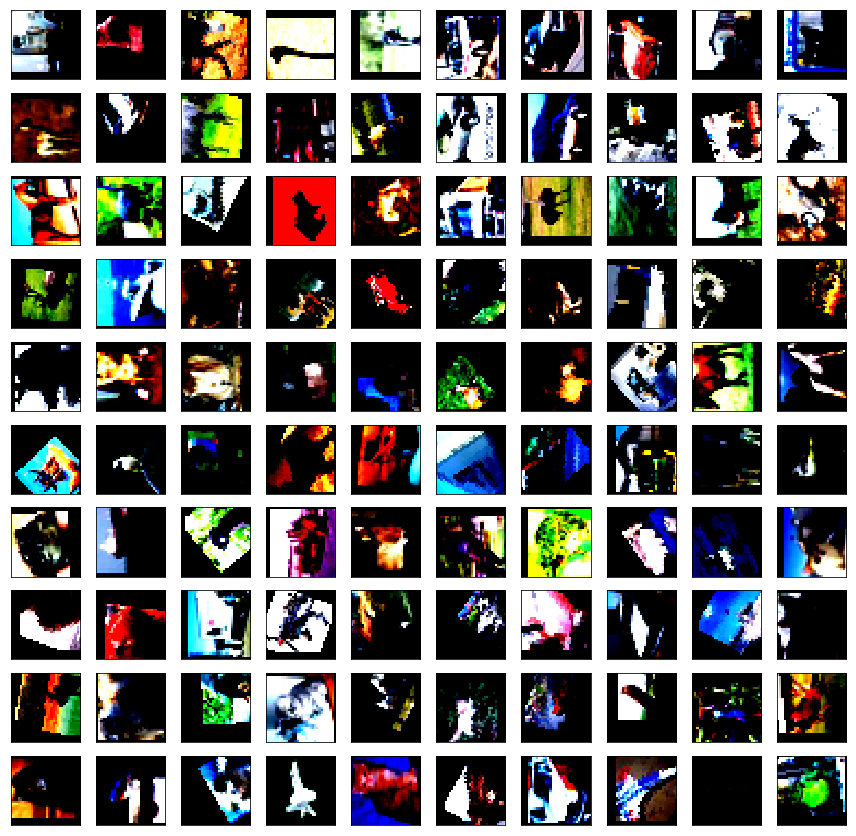

In [132]:
#Change trainloader_aug batchsize to 1 in order to plot images
fig,a = plt.subplots(10,10, figsize=(15,15))
for i,data in enumerate(trainloader_aug,0):
    a[i//10,i%10].imshow(data[0].squeeze().numpy().T)
    a[i//10,i%10].set_xticks([])
    a[i//10,i%10].set_yticks([])

In [77]:
resnet18_aug = ResNet18()
loss_train_resnet_aug, loss_val_resnet_aug = train_and_val(resnet18_aug,trainloader_aug,valloader ,epoch=15)

Epoch:1, batch_number:10, loss:2.3668786764144896
Epoch:2, batch_number:10, loss:2.343990612030029
Epoch:3, batch_number:10, loss:2.215052366256714
Epoch:4, batch_number:10, loss:1.9855645418167114
Epoch:5, batch_number:10, loss:1.9453829646110534
Epoch:6, batch_number:10, loss:1.9740843176841736
Epoch:7, batch_number:10, loss:1.909528911113739
Epoch:8, batch_number:10, loss:1.7350812554359436
Epoch:9, batch_number:10, loss:1.8244122385978698
Epoch:10, batch_number:10, loss:1.7953701496124268
Epoch:11, batch_number:10, loss:1.6115272998809815
Epoch:12, batch_number:10, loss:1.5861653447151185
Epoch:13, batch_number:10, loss:1.598862075805664
Epoch:14, batch_number:10, loss:1.5150087118148803
Epoch:15, batch_number:10, loss:1.4679024279117585


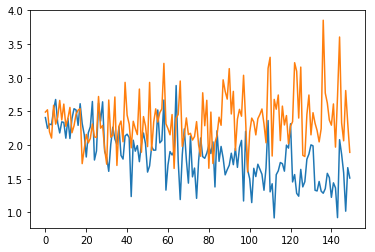

In [78]:
plt.plot(loss_train_resnet_aug)
plt.plot(loss_val_resnet_aug)

In [79]:
testing(trainloader, resnet18_aug)

Accuracy of the network: 55 %


In [80]:
testing(valloader, resnet18_aug)

Accuracy of the network: 22 %


In [81]:
vgg_aug = VGG('VGG11')
loss_train_vgg_aug, loss_val_vgg_aug = train_and_val(vgg_aug,trainloader_aug,valloader ,epoch=15)

Epoch:1, batch_number:10, loss:2.483361744880676
Epoch:2, batch_number:10, loss:2.7442853927612303
Epoch:3, batch_number:10, loss:2.536121392250061
Epoch:4, batch_number:10, loss:2.418593108654022
Epoch:5, batch_number:10, loss:2.5458295226097105
Epoch:6, batch_number:10, loss:2.2907047867774963
Epoch:7, batch_number:10, loss:2.1735876560211183
Epoch:8, batch_number:10, loss:2.0910793423652647
Epoch:9, batch_number:10, loss:2.1478642344474794
Epoch:10, batch_number:10, loss:1.9652956366539
Epoch:11, batch_number:10, loss:1.7880924582481383
Epoch:12, batch_number:10, loss:1.788287305831909
Epoch:13, batch_number:10, loss:1.7270042419433593
Epoch:14, batch_number:10, loss:1.787218689918518
Epoch:15, batch_number:10, loss:1.742711353302002


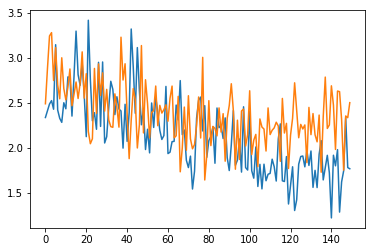

In [82]:
plt.plot(loss_train_vgg_aug)
plt.plot(loss_val_vgg_aug)

In [83]:
testing(trainloader, vgg_aug)

Accuracy of the network: 42 %


In [84]:
testing(valloader, vgg_aug)

Accuracy of the network: 21 %


## Wavelets

__Question 9:__ Use a Scattering Transform as an input to a ResNet-like architecture. You can find a baseline here: https://arxiv.org/pdf/1703.08961.pdf.

*Hint:* You can use the following package: https://www.kymat.io/

In [88]:
from kymatio import Scattering2D
import kymatio.datasets as scattering_datasets

scattering = Scattering2D(J=2, shape=(32, 32))
K = 81*3

class Scattering2dCNN(nn.Module):
    '''
        Simple CNN with 3x3 convs based on VGG
    '''
    def __init__(self, in_channels, classifier_type='cnn'):
        super(Scattering2dCNN, self).__init__()
        self.in_channels = in_channels
        self.classifier_type = classifier_type
        self.build()

    def build(self):
        cfg = [256, 256, 256, 'M', 512, 512, 512, 1024, 1024]
        layers = []
        self.K = self.in_channels
        self.bn = nn.BatchNorm2d(self.K)
        if self.classifier_type == 'cnn':
            for v in cfg:
                if v == 'M':
                    layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
                else:
                    conv2d = nn.Conv2d(self.in_channels, v, kernel_size=3, padding=1)
                    layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
                    self.in_channels = v

            layers += [nn.AdaptiveAvgPool2d(2)]
            self.features = nn.Sequential(*layers)
            self.classifier =  nn.Linear(1024*4, 10)


    def forward(self, x):
        x = self.bn(x.view(-1, self.K, 8, 8))
        if self.features:
            x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


model = Scattering2dCNN(K,'cnn')


In [89]:
def train_and_val_scat(net,epoch=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    loss_train=[]
    loss_val = []

    for epoch in range(epoch):  # loop over the dataset multiple times

        for g in optimizer.param_groups: # decreasing learning rate by 10% every epoch
            g['lr'] = 0.90*g['lr']

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(scattering(inputs))
            loss = criterion(outputs, labels)
            loss_train.append(loss.item())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every mini-batches
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                running_loss = 0.0
                
                for j, data in enumerate(valloader, 0):
                    inputs, labels = data
                    outputs = net(scattering(inputs))
                    lossv = criterion(outputs, labels)
                    loss_val.append(lossv.item())
                    
    return loss_train,loss_val

def testing_scat(testloader, net):
    correct = 0
    total = 0
    with torch.no_grad():
        for i,data in enumerate(testloader):
            images, labels = data
            outputs = net(scattering(images))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            if i % 100 == 99:    # print every 2000 mini-batches
                print(i, 'ème tested image')
    print('Accuracy of the network: %d %%' % (
        100 * correct / total))

In [90]:
loss_train_scatter2d, loss_val_scatter2d = train_and_val_scat(model,epoch=10)

[1,    10] loss: 2.678
[2,    10] loss: 2.571
[3,    10] loss: 2.229
[4,    10] loss: 2.316
[5,    10] loss: 1.970
[6,    10] loss: 1.487
[7,    10] loss: 1.499
[8,    10] loss: 1.241
[9,    10] loss: 0.862
[10,    10] loss: 0.645


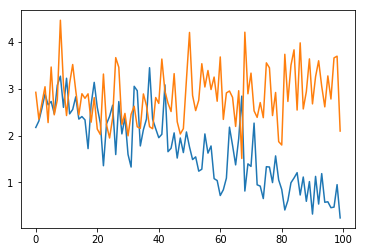

In [91]:
plt.plot(loss_train_scatter2d)
plt.plot(loss_val_scatter2d)

In [92]:
testing_scat(trainloader, model)

Accuracy of the network: 88 %


In [93]:
testing_scat(valloader, model)

Accuracy of the network: 29 %


# Conclusions

__Question 11:__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

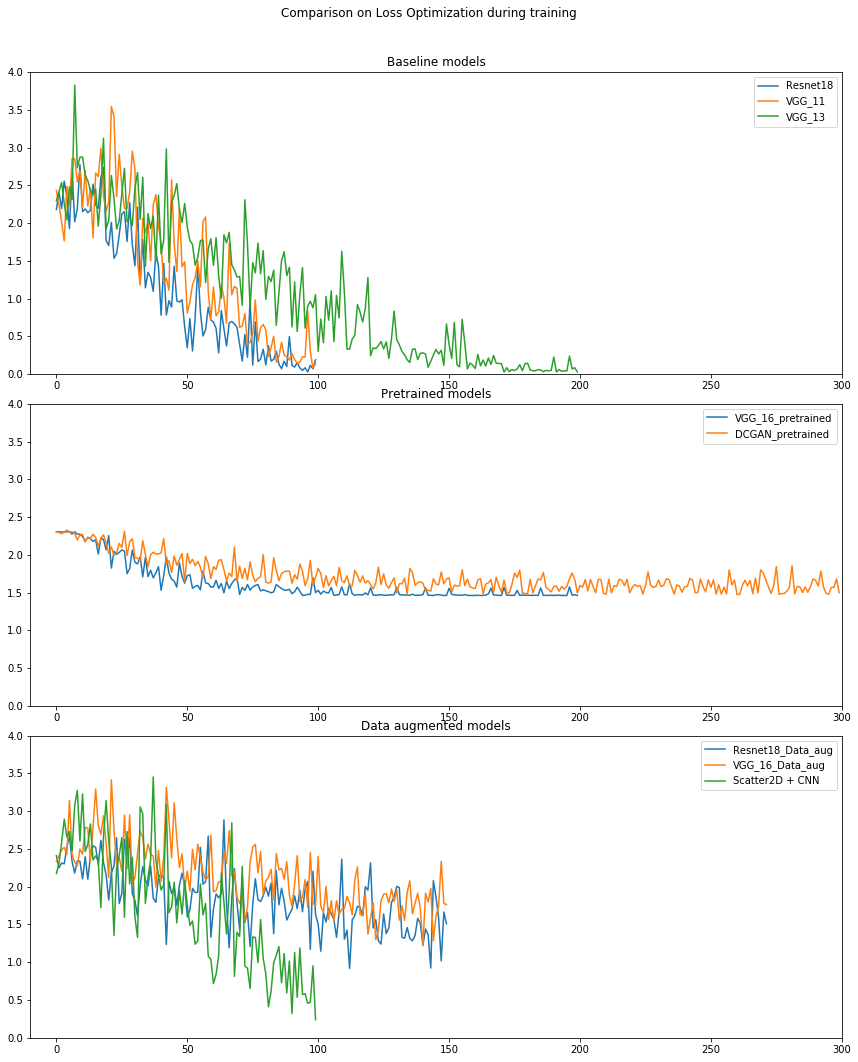

In [115]:
fig, a = plt.subplots(3,1,figsize=(12,15))
fig.suptitle('Comparison on Loss optimization during training') 
fig.tight_layout()
fig.subplots_adjust(top=0.92)
a[0].set_title('Baseline models')
a[0].plot(loss_train_resnet, label='Resnet18')
a[0].plot(loss_train_vgg, label='VGG_11')
a[0].plot(loss_train_vgg_13, label='VGG_13')
a[0].set_xlim(-10,300)
a[0].set_ylim(0,4)
a[0].legend()

a[1].set_title('Pretrained models')
a[1].plot(loss_train_vgg_pretrained, label= 'VGG_16_pretrained')
a[1].plot(loss_train_DCGAN, label='DCGAN_pretrained')
a[1].set_xlim(-10,300)
a[1].set_ylim(0,4)
a[1].legend()

a[2].set_title('Data augmented models')
a[2].plot(loss_train_resnet_aug, label='Resnet18_Data_aug')
a[2].plot(loss_train_vgg_aug, label='VGG_16_Data_aug')
a[2].plot(loss_train_scatter2d, label='Scatter2D + CNN')
a[2].set_xlim(-10,300)
a[2].set_ylim(0,4)
a[2].legend()

plt.show()

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|Resnet18| ***10*** | ***100%*** | ***20%*** |
|VGG_11| 20 | 100% | 48% |
|VGG13| ***10*** | ***100%*** | ***20%*** |
|VGG16_pretrained on ImageNet | 20 | 100% | 48% |
|DCGAN_pretrained| ***10*** | ***100%*** | ***20%*** |
|Resnet18_DataAugmentation| 20 | 100% | 48% |
|VGG16_DataAugmentation| ***10*** | ***100%*** | ***20%*** |
|Scatter2D +CNN | 20 | 100% | 48% |